<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/W266Multi%2BBinary_CK_T5_12_01__NoEmpath_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## T5 References

https://huggingface.co/docs/transformers/model_doc/t5

https://arxiv.org/pdf/1910.10683.pdf

https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_6_Machine_Translation.ipynb

http://seekinginference.com/applied_nlp/t5-class.html
http://seekinginference.com/NLP/T5_classification



#Initial Set up 

In this notebook 
a ) I am using data from GCS, from courtney which is cleaned for age and other additional columns , 
b) I am also removing AGE from the model and lower string transformations
c) cleaning up the notebook for only model as of now

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec  2 15:03:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# imports
import sys
import csv
from enum import Enum

#import unidecode 
#import unicodedata
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import re
import time
import random
import datetime

In [3]:
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q optuna

     |████████████████████████████████| 1.3 MB 7.0 MB/s 
     |████████████████████████████████| 5.8 MB 7.2 MB/s 
     |████████████████████████████████| 182 kB 74.8 MB/s 
     |████████████████████████████████| 7.6 MB 76.7 MB/s 
     |████████████████████████████████| 348 kB 7.0 MB/s 
     |████████████████████████████████| 209 kB 84.9 MB/s 
     |████████████████████████████████| 81 kB 12.2 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 147 kB 81.6 MB/s 
     |████████████████████████████████| 112 kB 85.0 MB/s 


In [4]:

import os, re
import time
import numpy as np
import pandas as pd

import io
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score,matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler



In [ ]:
SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
torch.cuda.amp.autocast(enabled=True)

In [7]:
torch.backends.cudnn.deterministic = True

# tell pytorch to use cuda
device = torch.device("cuda")

In [8]:
#imports and installs for feature engineering
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.7 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=f187adc360ab8e993da9ca08d9ca19ede69affdd889b5ed24244122022165dec
  Stored in directory: /root/.cache/pip/wheels/2a/e5/c2/fd8dad0a452927c85ecd3c6cbaa4748125246eed73d8303184
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 6.6 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=8ee1b482230a7d6e0634dcce15e7c687c2902e01eb3fa004c936d1747f774153
  Stored in directory: /root/.cache/pip/wheels/83/95/c0/42b43fb15eb48e4f5a67cba8915540cb2783591c59c037a9e5
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    uploaded = files.upload()


def config_GCloud():
    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

 
    return gcloud_bucket, gcloud_bucket_name


In [10]:
upload_gcloud_credentials()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json


In [11]:
bucket, bucket_name = config_GCloud()

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
t5_dev_uniform.parquet
t5

In [12]:
# setup google drive access for checkpoint file

from google.colab import drive
drive.mount('/content/drive')

!ls -lrt "/content/drive/My Drive"
!ls -lrt "/content/drive/My Drive/W266/MBTI/model_checkpoints"

Mounted at /content/drive
total 20
drwx------ 2 root root 4096 Jan 24  2022 'Colab Notebooks'
drwx------ 2 root root 4096 Oct 21 00:00  content
drwx------ 2 root root 4096 Oct 21 17:29  ULondon
drwx------ 2 root root 4096 Oct 21 17:31  MIDS
drwx------ 2 root root 4096 Nov 22 16:09  W266
total 1344494
-rw------- 1 root root 445902488 Nov 22 22:37 bert_multibinary_1122_noemote.hdf5
-rw------- 1 root root 445902488 Nov 28 19:50 bert_multibinary_1120.hdf5
-rw------- 1 root root 242086395 Dec  2 03:22 t5-classification.pt
-rw------- 1 root root      1473 Dec  2 03:22 config.json
-rw------- 1 root root 242070267 Dec  2 03:22 pytorch_model.bin
-rw------- 1 root root      2374 Dec  2 03:22 tokenizer_config.json
-rw------- 1 root root    791656 Dec  2 03:22 spiece.model
-rw------- 1 root root      2201 Dec  2 03:22 special_tokens_map.json


In [13]:
t5_model_name='t5-small'

In [14]:
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name )

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [15]:
print(t5_tokenizer.eos_token_id)
print(t5_tokenizer.bos_token_id)
print(t5_tokenizer.unk_token_id)
print(t5_tokenizer.pad_token_id)

1
None
2
0


# Data Prep

In [16]:
max_length = 512
batch_size = 16

In [17]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [18]:
def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')


In [19]:


# for T5
separator_token = " </s>"
prefix_text = 'multilabel classification: '

# for Bert
# separator_token = " [SEP] "
# prefix_text = ''


class Features(Enum):
    all_features = 1
    no_username = 2
    no_emotions = 3
    no_lexicon = 4
    no_postags = 5

def combine_no_username(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text + df['Age'].astype(str)+ separator_token + df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_no_emotion(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token + "pos tags: "+df['postags'].astype(str)+  separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_lexical(df):
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_pos(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_all(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df



def add_features( df, features_to_include ):

    if features_to_include is Features.all_features:
        return combine_all(df)

    elif features_to_include is Features.no_username:
        return combine_no_username(df)

    elif features_to_include is Features.no_emotions:
        return combine_no_emotion(df)

    elif features_to_include is Features.no_lexicon:
        return combine_no_lexical(df)

    else: # features_to_include is Features.no_postags:
        return combine_no_pos(df)


 

    

In [ ]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')

#remove gender from the train data set ( rather than dealing with de-biasing )
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
dev_mbti_data = dev_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
test_mbti_data = test_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [20]:
# define sample sizes for each run

# start with small dimensions to try out the model
n_train_samples = 120000
n_test_samples = 93106
n_dev_samples = 20000

In [ ]:
# add features, but only to the number of samples dictated by the sample size defined above.

train_mbti_short_df = train_mbti_data[ 0 : n_train_samples ]
test_mbti_short_df = test_mbti_data[ 0 : n_test_samples ]
dev_mbti_short_df = dev_mbti_data[ 0: n_dev_samples ]

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


train_df = add_features(train_mbti_short_df, Features.no_lexicon)
test_df = add_features(test_mbti_short_df, Features.no_lexicon)
dev_df = add_features( dev_mbti_short_df, Features.no_lexicon)


<ipython-input-19-465bc000b9c4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
<ipython-input-19-465bc000b9c4>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
<ipython-input-19-465bc000b9c4>:36: Settin

In [ ]:
train_df.head()

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J,emotions,postags,combined
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True,"negative 2, positive 2, anticipation 1","space 1, pron 18, aux 17, part 8, verb 19, adv...",multilabel classification: oneandonly </s>37.0...
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False,"negative 2, anger 1, anticipation 1, joy 1, po...","space 2, propn 2, adp 7, det 3, adj 7, noun 6,...",multilabel classification: thalassa </s>45.0 <...
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False,"surprise 1, positive 3, joy 1, trust 1","noun 6, verb 5, adj 3, punct 6, pron 5, aux 3,...",multilabel classification: lady_x </s>46.0 </s...
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True,"fear 2, negative 2, trust 3, positive 2, joy 1...","space 1, pron 9, verb 7, punct 8, aux 6, adj 7...",multilabel classification: eagle </s>31.0 </s>...
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False,"joy 1, positive 1, trust 1","punct 2, noun 1",multilabel classification: ayoitsstepho </s>31...


In [ ]:
# write these out to files

write_parquet_google_cloud( train_df, 't5_train_uniform.parquet')
write_parquet_google_cloud( test_df, 't5_test_uniform.parquet')
write_parquet_google_cloud( dev_df, 't5_dev_uniform.parquet')

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
t5_dev_uniform.parquet
t5

In [21]:
train_df = read_parquet_google_cloud('t5_train_uniform.parquet')
test_df = read_parquet_google_cloud('t5_test_uniform.parquet')
dev_df = read_parquet_google_cloud('t5_dev_uniform.parquet')

train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


In [22]:
# create pandas dataframe with the correct format of "prefix" + "input_text" and "target_text"


def create_T5_df( input_df, labels_df, n_rows ):
    input_text_list = input_df['combined']
    target_text_list = labels_df['MBTI Type']

    combined_dict = { 'input_text': input_text_list, 'target_text': target_text_list}

    return pd.DataFrame(combined_dict)


In [23]:
# create custom dfs with the 3 columns necessary for creating prefix, input text and target text 

t5_train_df = create_T5_df(train_df, train_mbti_short_labels_df, n_train_samples )
t5_test_df = create_T5_df(test_df, test_mbti_short_labels_df, n_test_samples )
t5_dev_df = create_T5_df(dev_df, dev_mbti_short_labels_df, n_dev_samples )

In [ ]:
t5_train_df.head()

,input_text,target_text
0,multilabel classification: oneandonly </s>37.0...,INFJ
1,multilabel classification: thalassa </s>45.0 <...,ISFP
2,multilabel classification: lady_x </s>46.0 </s...,ENFP
3,multilabel classification: eagle </s>31.0 </s>...,ISTJ
4,multilabel classification: ayoitsstepho </s>31...,ISFP


In [24]:
def preprocess_data( input_text, target_text, tokenizer, max_length=512 ):

    input_ids = []
    input_attention_masks = []

    target_ids = []

    input_encodings = tokenizer.encode_plus(input_text,
                                            add_special_tokens=True, # add tokens relative to model
                                            truncation=True,  # truncate longer inputs
                                            max_length=max_length,  # set max_length
                                            padding = 'max_length',  # add padding
                                            return_attention_mask=True,  # create attn masks
                                            return_tensors='pt')  #return pytorch tensors

    # Extract input ids and attention masks, add to corresponding lists
    input_ids.append(input_encodings["input_ids"])
    input_attention_masks.append(input_encodings["attention_mask"])

    target_ids.append(tokenizer(target_text + " </s>"))

    return [input_ids,input_attention_masks], [target_ids]


In [25]:
# figure out the max_length for the targets after tokenizing
target_text_list = [ label + " </s>" for label in train_mbti_short_labels_df['MBTI Type']]
target_tokens_length = []

for i in range( 0, len(target_text_list)):
    target_tokens_length.append(len(t5_tokenizer.tokenize(target_text_list[i])))

target_len_df = pd.DataFrame({'len_target_tokens': target_tokens_length})

mean_len = target_len_df['len_target_tokens'].mean()
max_len = target_len_df['len_target_tokens'].max()

print( "Mean target tokens len:", mean_len, "Max target tokens len:", max_len )

max_target_length = max_len


Mean target tokens len: 3.74945 Max target tokens len: 4


In [26]:
def tokenize_textlist( text_list, tokenizer, max_length = 512 ):

    token_ids = []
    token_attention_masks = []

    for text in text_list:
        token_encodings = tokenizer.encode_plus(text,
                                            add_special_tokens=True, # add tokens relative to model
                                            truncation=True,  # truncate longer inputs
                                            max_length=max_length,  # set max_length
                                            padding = 'max_length',  # add padding
                                            return_attention_mask=True,  # create attn masks
                                            return_tensors='pt')  #return pytorch tensors

        token_ids.append(token_encodings['input_ids'])
        token_attention_masks.append(token_encodings['attention_mask'])

    return torch.cat(token_ids, dim=0), torch.cat(token_attention_masks, dim=0)



In [ ]:
# tokenize train set

train_input_ids, train_attention_masks = tokenize_textlist( t5_train_df['input_text'], t5_tokenizer, 512 )
train_target_ids, train_target_attention_masks = tokenize_textlist( t5_train_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for training
train_dataset = TensorDataset( train_input_ids, train_attention_masks, train_target_ids, train_target_attention_masks )

# create a dataloader for training
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = False)


/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [ ]:
# tokenize test set

test_input_ids, test_attention_masks = tokenize_textlist( t5_test_df['input_text'], t5_tokenizer, 512 )
test_target_ids, test_target_attention_masks = tokenize_textlist( t5_test_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for test
test_dataset = TensorDataset( test_input_ids, test_attention_masks, test_target_ids, test_target_attention_masks )

# create a dataloader for test
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = False)



In [ ]:
# tokenize dev set

dev_input_ids, dev_attention_masks = tokenize_textlist( t5_dev_df['input_text'], t5_tokenizer, 512 )
dev_target_ids, dev_target_attention_masks = tokenize_textlist( t5_dev_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for dev
dev_dataset = TensorDataset( dev_input_ids, dev_attention_masks, dev_target_ids, dev_target_attention_masks )

# create a dataloader for dev
dev_dataloader = DataLoader(dev_dataset, batch_size = 16, shuffle = False)



# Create Model and Stages for it

the following code is largely cut and paste from http://seekinginference.com/applied_nlp/t5-class.html


In [ ]:
def train(model, dataloader, optimizer):

    # capture time
    total_t0 = time.time()

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    # reset total loss for epoch
    train_total_loss = 0
    total_train_f1 = 0

    # put model into traning mode
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):

        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Unpack this training batch from our dataloader:
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # clear previously calculated gradients
        optimizer.zero_grad()

        # runs the forward pass with autocasting.
        with autocast():
            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            train_total_loss += loss.item()

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss
        }
    )

    # training time end
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | trn loss | trn time ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {training_time:}")

    return training_stats


def validating(model, dataloader):

    # capture validation time
    total_t0 = time.time()

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            total_valid_loss += loss.item()

    # calculate the average loss over all of the batches.
    global avg_val_loss
    avg_val_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_val_loss,
            'Val PPL.': np.exp(avg_val_loss)
        }
    )

    # capture end validation time
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | val loss | val ppl | val time")
    print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {np.exp(avg_val_loss):.3f} | {training_time:}")

    return valid_stats


def testing(model, dataloader):

    print("")
    print("Running Testing...")

    # measure training time
    t0 = time.time()

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_test_loss = 0
    total_test_acc = 0
    total_test_f1 = 0
    predictions = []
    actuals = []

    # evaluate data for one epoch
    for step, batch in enumerate(dataloader):
        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

        # Unpack this training batch from our dataloader:
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            total_test_loss += loss.item()

            generated_ids = model.generate(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    max_length=max_target_length
                    )

            preds = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [t5_tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in b_target_ids]

            total_test_acc += accuracy_score(target, preds)
            total_test_f1 += f1_score(preds, target,
                                       average='weighted',
                                       labels=np.unique(preds))
            predictions.extend(preds)
            actuals.extend(target)

    # calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader)

    avg_test_acc = total_test_acc / len(test_dataloader)

    avg_test_f1 = total_test_f1 / len(test_dataloader)

    # Record all statistics from this epoch.
    test_stats.append(
        {
            'Test Loss': avg_test_loss,
            'Test PPL.': np.exp(avg_test_loss),
            'Test Acc.': avg_test_acc,
            'Test F1': avg_test_f1
        }
    )
    global df2
    temp_data = pd.DataFrame({'predicted': predictions, 'actual': actuals})
    df2 = df2.append(temp_data)

    return test_stats
    

# time function
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training Preparation


In [ ]:
# instantiate model T5 transformer with a language modeling head on top
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).cuda()  # to GPU

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
# Adam w/ Weight Decay Fix
# set to optimizer_grouped_parameters or model.parameters()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5
                  )

# epochs
epochs = 1

# lr scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# create gradient scaler for mixed precision
scaler = GradScaler()


In [ ]:
print( "Length train_dataloader:", len(train_dataloader))
print( "Total steps:", total_steps)

Length train_dataloader: 7500
Total steps: 7500


In [ ]:
# create training result storage
training_stats = []
valid_stats = []
best_valid_loss = float('inf')

# for each epoch
for epoch in range(epochs):
    # train
    train(model, train_dataloader, optimizer)
    # validate
    validating(model, dev_dataloader)
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        # save best model for use later
        torch.save(model.state_dict(), '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')  # torch save
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save
        t5_tokenizer.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save



======== Epoch 1 / 1 ========
Training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  Batch    40  of  7,500.
  Batch    80  of  7,500.
  Batch   120  of  7,500.
  Batch   160  of  7,500.
  Batch   200  of  7,500.
  Batch   240  of  7,500.
  Batch   280  of  7,500.
  Batch   320  of  7,500.
  Batch   360  of  7,500.
  Batch   400  of  7,500.
  Batch   440  of  7,500.
  Batch   480  of  7,500.
  Batch   520  of  7,500.
  Batch   560  of  7,500.
  Batch   600  of  7,500.
  Batch   640  of  7,500.
  Batch   680  of  7,500.
  Batch   720  of  7,500.
  Batch   760  of  7,500.
  Batch   800  of  7,500.
  Batch   840  of  7,500.
  Batch   880  of  7,500.
  Batch   920  of  7,500.
  Batch   960  of  7,500.
  Batch 1,000  of  7,500.
  Batch 1,040  of  7,500.
  Batch 1,080  of  7,500.
  Batch 1,120  of  7,500.
  Batch 1,160  of  7,500.
  Batch 1,200  of  7,500.
  Batch 1,240  of  7,500.
  Batch 1,280  of  7,500.
  Batch 1,320  of  7,500.
  Batch 1,360  of  7,500.
  Batch 1,400  of  7,500.
  Batch 1,440  of  7,500.
  Batch 1,480  of  7,500.
  Batch 1,520  of  7,500.
  Batch 1,56

In [ ]:
# organize results
pd.set_option('precision', 3)
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
df_stats


,Train Loss,Val Loss,Val PPL.
Epoch,,,
1,0.533,0.224,1.251


In [ ]:
# test the model
df2 = pd.DataFrame({'predicted': [], 'actual': []})
test_stats = []
model.load_state_dict(torch.load('/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt'))

<All keys matched successfully>

In [ ]:
testing( model, test_dataloader )


Running Testing...
  Batch    40  of  5,820.    Elapsed: 0:00:06.
  Batch    80  of  5,820.    Elapsed: 0:00:12.
  Batch   120  of  5,820.    Elapsed: 0:00:18.
  Batch   160  of  5,820.    Elapsed: 0:00:24.
  Batch   200  of  5,820.    Elapsed: 0:00:30.
  Batch   240  of  5,820.    Elapsed: 0:00:37.
  Batch   280  of  5,820.    Elapsed: 0:00:43.
  Batch   320  of  5,820.    Elapsed: 0:00:49.
  Batch   360  of  5,820.    Elapsed: 0:00:55.
  Batch   400  of  5,820.    Elapsed: 0:01:01.
  Batch   440  of  5,820.    Elapsed: 0:01:07.
  Batch   480  of  5,820.    Elapsed: 0:01:13.
  Batch   520  of  5,820.    Elapsed: 0:01:19.
  Batch   560  of  5,820.    Elapsed: 0:01:25.
  Batch   600  of  5,820.    Elapsed: 0:01:31.
  Batch   640  of  5,820.    Elapsed: 0:01:37.
  Batch   680  of  5,820.    Elapsed: 0:01:44.
  Batch   720  of  5,820.    Elapsed: 0:01:50.
  Batch   760  of  5,820.    Elapsed: 0:01:56.
  Batch   800  of  5,820.    Elapsed: 0:02:02.
  Batch   840  of  5,820.    Elapsed: 0:

[{'Test Loss': 0.2247973806435991,
  'Test PPL.': 1.2520689970741736,
  'Test Acc.': 0.7444265463917525,
  'Test F1': 0.7345140500488436}]

In [ ]:
df_test_stats = pd.DataFrame(data=test_stats)
print(df_test_stats)

   Test Loss  Test PPL.  Test Acc.  Test F1
0      0.225      1.252      0.744    0.735


In [ ]:
print(df2.head(50))

   predicted actual
0       ENFP   ENFP
1       ENFJ   ENFJ
2       ENTP   INTP
3       INTP   INTP
4       ESFJ   ESFJ
5       ENTP   ENTP
6       INFP   INFP
7       ENTJ   INFP
8       INFP   INFP
9       INTP   INFJ
10      ENFP   ENFP
11      ESFP   ESFP
12      ISFJ   ISFJ
13      ISTP   ISTP
14      INTJ   INTJ
15      ENFP   ENFP
16      ESTJ   ESTJ
17      INFJ   INFJ
18      INFJ   INFJ
19      ENFP   ENFP
20      ESTJ   ESTJ
21      ESFP   ESFP
22      ENFP   ENFP
23      ESTJ   ESTJ
24      INTP   INTP
25      INTJ   INTJ
26      INTP   INTP
27      ISTP   ISTP
28      ISFP   ISFP
29      INTJ   INTJ
30      ISFP   ISFP
31      ISTP   ISTP
32      INTP   INFJ
33      ENFP   ENFP
34      ESFP   ENFJ
35      INTJ   INTJ
36      INFJ   INFJ
37      ENFP   ENFP
38      ESFJ   ESFJ
39      ISTP   ISTP
40      ENFP   ENFP
41      ENTJ   ENTJ
42      ENTP   ENTP
43      INFP   INFP
44      ENTJ   ENTJ
45      ISFP   ISFP
46      ISFP   ISFP
47      ENTP   INFJ
48      INTJ   INTJ


# Multihead attention Model with Multiclass Classification

In [ ]:
from sklearn.metrics import confusion_matrix

#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

def document_multimodel_run( model_type,
                            mbti_model,
                            predicted_results,
                            actual_values ):


 
   #Multiclass classification
  print(classification_report(actual_values, predicted_results))

  cr_multi = classification_report(actual_values, predicted_results)

  cm_multi = confusion_matrix(actual_values, predicted_results)
  cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  

Question 3 : Do we need to report on all 5 different loss and accuracy scores for test

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ASFP       0.00      0.00      0.00         0
        ENFJ       0.85      0.81      0.83      2920
        ENFP       0.91      0.70      0.80     11048
        ENTJ       0.71      0.85      0.77      4186
        ENTP       0.61      0.77      0.68      8567
        ESFJ       0.86      0.95      0.90      2169
        ESFP       0.87      0.95      0.91      2126
        ESTJ       0.86      0.95      0.90      2243
        ESTM       0.00      0.00      0.00         0
        ESTP       0.72      0.92      0.80      1840
        INFJ       0.75      0.69      0.72      9275
        INFP       0.86      0.57      0.69     12497
        INTJ       0.83      0.77      0.80     12850
        INTP       0.72      0.68      0.70     12925
        ISFJ       0.53      0.84      0.65      1061
        ISFP       0.84      0.89      0.86      3946
        ISTB       0.00      0.00      0.00         0
        ISTJ       0.46    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-48-01b4b93faca9>:21: RuntimeWarning: invalid value encountered in true_divid

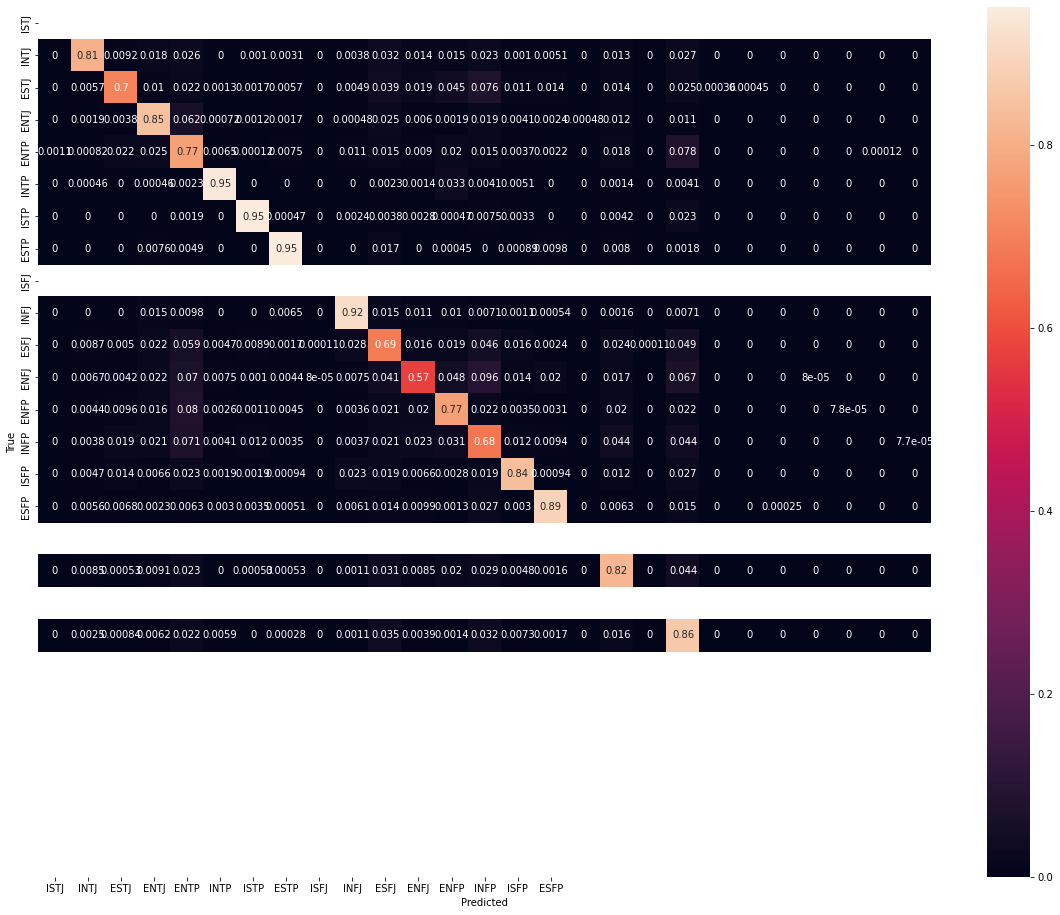

In [ ]:
document_multimodel_run('mbti_t5_model',
                         model,
                         df2['predicted'],
                         df2['actual'] )


